In [44]:
from egocom import audio
from egocom.multi_array_alignment import gaussian_kernel
from scipy.io import wavfile
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
def gaussian_smoothing(arr, samplerate = 44100, window_size = 0.1):
    '''Returns a locally-normalized array by dividing each point by a the 
    sum of the points around it, with greater emphasis on the points 
    nearest (using a Guassian convolution)
    
    Parameters
    ----------
    arr : np.array
    samplerate : int
    window_size : float (in seconds)
    
    Returns
    -------
    A Guassian smoothing of the input arr'''
    
    kern = gaussian_kernel(kernel_length=int(samplerate * window_size), nsigma=3)
    return np.convolve(arr, kern, 'same')

In [3]:
# Tests for audio.avg_pool_1d

def test_exact_recoverability(
    arr = range(10),
    pool_size = 4,
    weights = [0.2,0.3,0.3,0.2],
): 
    '''Verify that downsampled signal can be fully recovered exactly.'''
    complete_result = audio.avg_pool_1d(range(10), pool_size, filler = True, weights = weights)
    downsampled_result = audio.avg_pool_1d(range(10), pool_size, filler = False, weights = weights)
    # Try to recover filled_pooled_mags using the downsampled pooled_mags
    upsampled_result = audio.upsample_1d(downsampled_result, len(arr), pool_size)
    assert(np.all(upsampled_result == complete_result))
    
    
def test_example(
    arr = range(10),
    pool_size = 4,
    weights = [0.2,0.3,0.3,0.2],
):
    '''Verify that avg_pool_1d produces the result we expect.'''
    result = audio.avg_pool_1d(range(10), pool_size, weights = weights)
    expected = np.array([1.5, 1.5, 1.5, 1.5, 5.5, 5.5, 5.5, 5.5, 8.5, 8.5])
    assert(np.all(result - expected < 1e-6))
    
test_exact_recoverability()
test_example()

In [4]:
samplerate = 44100
data_dir = '/Users/cgn/Dropbox (Facebook)/EGOCOM/raw_audio/wav/'

fn_dict = {}
for fn in sorted(os.listdir(data_dir)):
    key = fn[9:23] + fn[32:37] if 'part' in fn else fn[9:21]
    fn_dict[key] = fn_dict[key] + [fn] if key in fn_dict else [fn]

In [5]:
for key in list(fn_dict.keys())[28:29]:
    print(key)
    fns = fn_dict[key]
    wavs = [wavfile.read(data_dir + fn)[1] for fn in fns]
    duration = min(len(w) for w in wavs)
    wavs = np.stack([w[:duration] for w in wavs])
    break

day_2__con_2__part1


In [6]:
import sounddevice as sd

In [38]:
wavs.sum(axis = 0).shape

(11249664, 2)

In [56]:
wavs[:,:,1].shape

(2, 11249664)

In [60]:
wavs[:,:,1].astype(float)[1, samplerate*10:samplerate*20].shape

(441000,)

In [10]:
wavs.shape

(2, 11249664, 2)

In [13]:
wavs[0,samplerate*10:samplerate*20].sum(axis = 1).shape

(441000,)

In [8]:
wavs[0,samplerate*10:samplerate*20,0].shape

(441000,)

In [49]:
sd.play(wavs[0,samplerate*20:samplerate*30,:], samplerate)

In [16]:
sd.play(wavs[0,samplerate*10:samplerate*20].sum(axis = 1), samplerate)

TypeError: Unsupported data type: 'int64'

In [9]:
sd.play(wavs[0,samplerate*10:samplerate*20,0], samplerate)


In [40]:
%%time
# Only use the magnitudes of both left and right for each audio wav.
mags = abs(wavs).sum(axis = 2) 
# mags = abs(wavs[:,:,1]) # Right channel only,

# DOWNSAMPLED (POOLED) Discretized/Fast (no overlap) gaussian smoothing with one-second time window.
window = 0.5
window_length = int(samplerate * window)
kwargs = {
    'pool_size': window_length, 
    'weights': gaussian_kernel(kernel_length=window_length),
    'filler': False,
}
%time pooled_mags = np.apply_along_axis(audio.avg_pool_1d, 1, mags, **kwargs) 

# Create noisy speaker labels
threshold = np.percentile(pooled_mags, 10, axis = 1)
no_one_speaking = (pooled_mags > np.expand_dims(threshold, axis = 1)).sum(axis = 0) == 0
speaker_labels = np.argmax(pooled_mags, axis = 0)
speaker_labels[no_one_speaking] = -1

print('Total time required to produce labels for audio matrix of shape:', wavs.shape)

CPU times: user 125 ms, sys: 1.29 ms, total: 126 ms
Wall time: 31.7 ms
Total time required to produce labels for audio matrix of shape: (2, 11249664, 2)
CPU times: user 500 ms, sys: 94 ms, total: 594 ms
Wall time: 501 ms


CPU times: user 362 ms, sys: 141 ms, total: 503 ms
Wall time: 142 ms


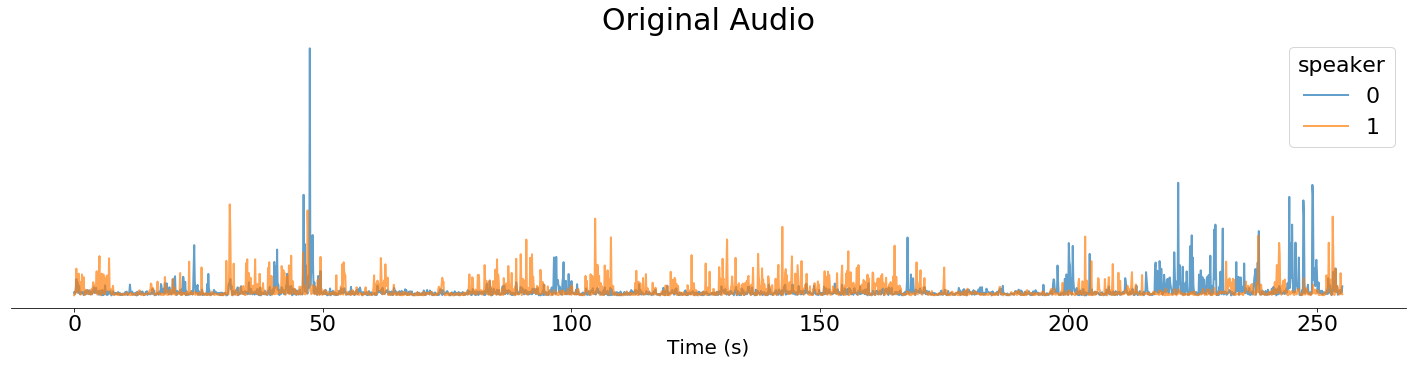

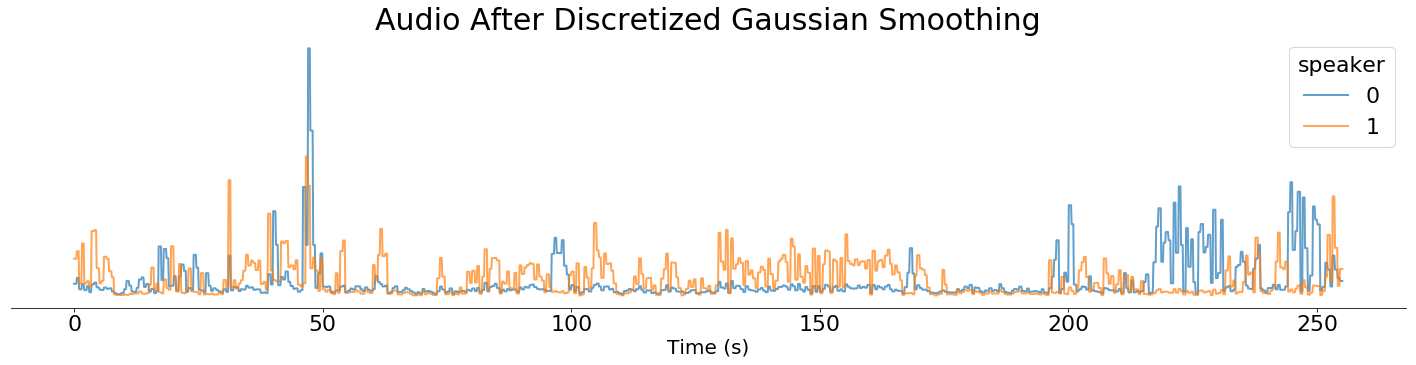

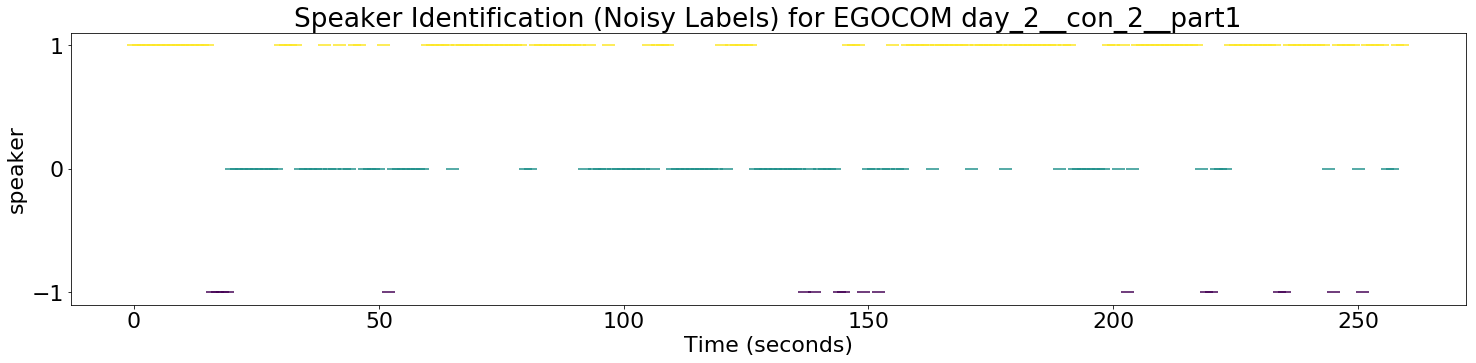

Notes: Speaker 0, 1, 2 are the participants. Speaker -1 implies no one is speaking, which occurs when the magnitude of all speaker signals < 10th percentile.


In [45]:
len_seconds = 260
downsample = 5000 # increase to plot faster

# Plot audio before smoothing
ax, lines = audio.plot_wav(mags[:, :samplerate * len_seconds].T, downsample=downsample, alpha = 0.7, linewidth = 2)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_ticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = plt.legend(iter(lines), [0,1,2], title = 'speaker')
_ = ax.set_title('Original Audio', fontsize = 30)

# Discretized/Fast (no overlap) gaussian smoothing with one-second time window.
kwargs = {
    'pool_size': window_length, 
    'weights': gaussian_kernel(kernel_length=window_length),
    'filler': True,
}
%time filled_pooled_mags = np.apply_along_axis(audio.avg_pool_1d, 1, mags, **kwargs) 

# Plot audio after smoothing
ax, lines = audio.plot_wav(filled_pooled_mags[:, :samplerate * len_seconds].T, downsample=downsample, alpha = 0.7, linewidth = 2)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_ticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = plt.legend(iter(lines), [0,1,2], title = 'speaker')
_ = ax.set_title('Audio After Discretized Gaussian Smoothing', fontsize = 30)
plt.show()

_ = plt.figure(figsize=(25, 5))
_ = plt.scatter(range(len(speaker_labels))[:len_seconds], speaker_labels[:len_seconds], c = speaker_labels[:len_seconds], marker="_", s=170)
_ = plt.ylabel("speaker")
_ = plt.yticks(np.unique(speaker_labels))
_ = plt.xlabel("Time (seconds)")
_ = plt.title("Speaker Identification (Noisy Labels) for EGOCOM " + key)
_ = plt.show()
print("Notes: Speaker 0, 1, 2 are the participants. Speaker -1 implies no one is speaking, which occurs when the magnitude of all speaker signals < 10th percentile.")

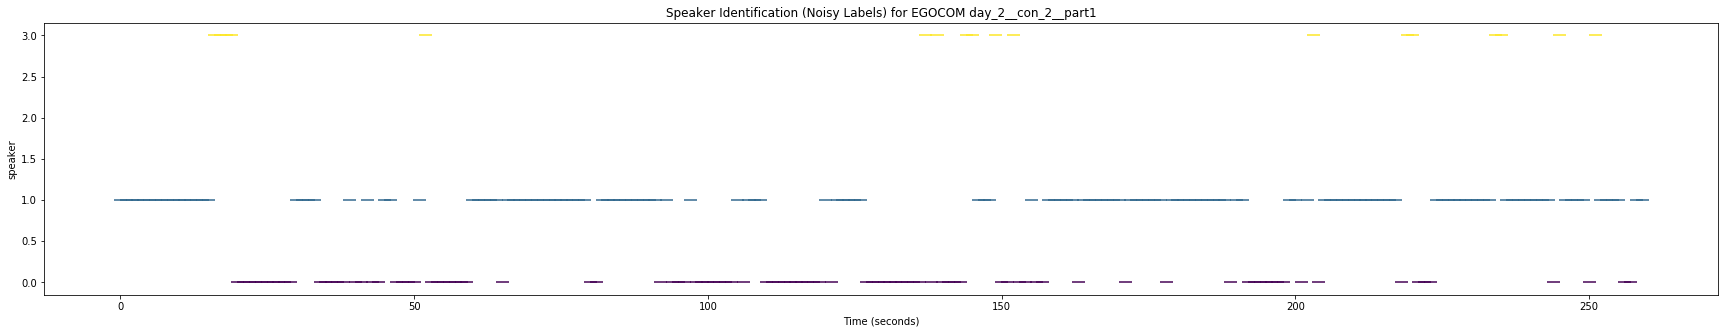

Notes: Speaker 0, 1, 2 are the participants. Speaker 3 implies no one is speaking, which occurs when the magnitude of all speaker signals < 10th percentile.


In [34]:
_ = plt.figure(figsize=(30, 5))
_ = plt.scatter(range(len(speaker_labels))[:len_seconds], speaker_labels[:len_seconds], c = speaker_labels[:len_seconds], marker="_", s=170)
_ = plt.ylabel("speaker")
_ = plt.xlabel("Time (seconds)")
_ = plt.title("Speaker Identification (Noisy Labels) for EGOCOM " + key)
_ = plt.show()
print("Notes: Speaker 0, 1, 2 are the participants. Speaker 3 implies no one is speaking, which occurs when the magnitude of all speaker signals < 10th percentile.")